# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [1]:
# This code is running on kaggle.

In [2]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 3.3.1
    Uninstalling datasets-3.3.1:
      Successfully uninstalled datasets-3.3.1


### Import Packages

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [4]:
!nvidia-smi

Fri Apr 11 00:45:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [5]:
set_seed(0)

# Prepare Data

### Define Dataset

In [6]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [7]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 4

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

# test
# print(num_classes)  # 167

README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [8]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

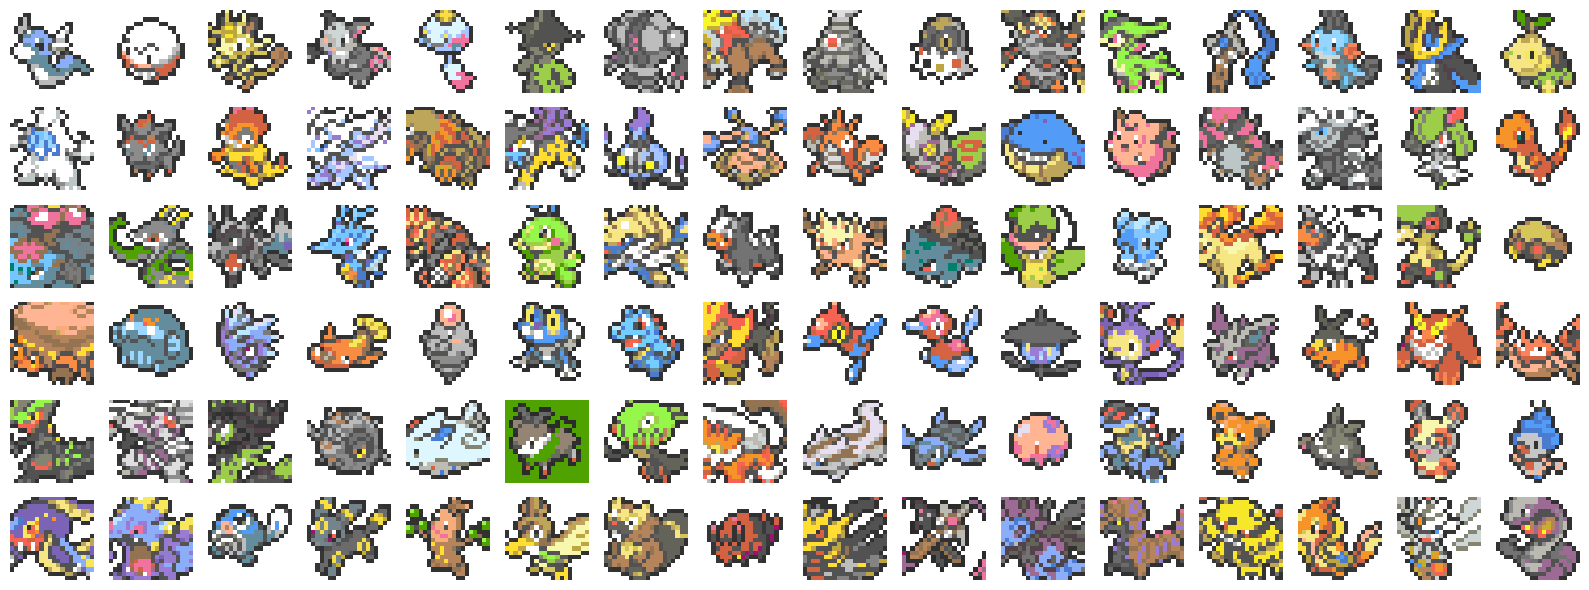

In [9]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

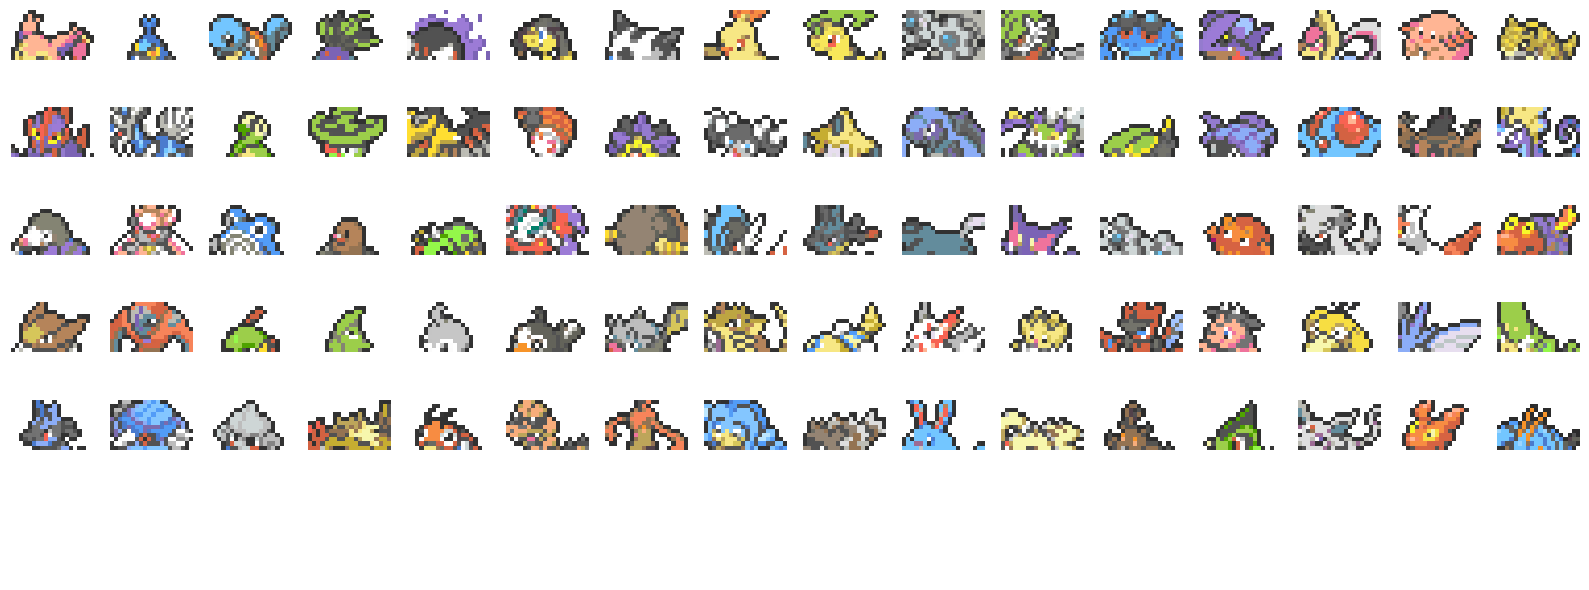

In [10]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


#### GPT-2 Config & Model

In [11]:
# # Define GPT-2 model configuration as a dictionary
# gpt2_config = {
#     "activation_function": "gelu_new",        # Activation function used in the model
#     "architectures": ["GPT2LMHeadModel"],     # Specifies the model type
#     "attn_pdrop": 0.1,                        # Dropout rate for attention layers
#     "embd_pdrop": 0.1,                        # Dropout rate for embeddings
#     "initializer_range": 0.02,                # Standard deviation for weight initialization
#     "layer_norm_epsilon": 1e-05,              # Small constant to improve numerical stability in layer norm
#     "model_type": "gpt2",                     # Type of model
#     "n_ctx": 128,                             # Context size (maximum sequence length)
#     "n_embd": 64,                             # Embedding size
#     "n_head": 2,                              # Number of attention heads
#     "n_layer": 2,                             # Number of transformer layers
#     "n_positions": 400,                       # Maximum number of token positions
#     "resid_pdrop": 0.1,                       # Dropout rate for residual connections
#     "vocab_size": num_classes,                # Number of unique tokens in vocabulary
#     "pad_token_id": None,                     # Padding token ID (None means no padding token)
#     "eos_token_id": None,                     # End-of-sequence token ID (None means not explicitly defined)
# }

# # Load GPT-2 model configuration from dictionary
# config = GPT2Config.from_dict(gpt2_config)

# # Load the model using the configuration defined above
# model = AutoModelForCausalLM.from_config(config)

#### Llama Config & Model

In [12]:
from transformers import LlamaConfig, LlamaForCausalLM

# Define Llama config
config = LlamaConfig(
    vocab_size=num_classes,            # 詞表大小: Tokenizer 所能產生的 token 數量
    hidden_size=768,                   # 每層的隱藏層維度: 每層的輸出維度；也是 embedding 的維度
    intermediate_size=3072,            # Feedforward 層的中間層維度（通常是 hidden_size 的 2~4 倍）
    num_hidden_layers=12,               # Transformer 的層數
    num_attention_heads=12,             # Attention 頭數（注意要整除 hidden_size）(注意力計算是顯存大戶)
    num_key_value_heads=None,          # 用於 Multi-query 或 grouped attention；若為 None，則與 attention heads 相同
    hidden_act="gelu",                 # 激活函數: gelu 在圖片 token 上有更穩定學習效果
    max_position_embeddings=1024,      # 最大輸入長度
    initializer_range=0.02,            # 權重初始化範圍
    rms_norm_eps=1e-5,                 # RMSNorm epsilon
    use_cache=True,                    # 是否啟用 cache（推理加速）
    pad_token_id=None,                 # Padding token ID
    bos_token_id=None,                 # 開始 token ID
    eos_token_id=None,                 # 結束 token ID
    pretraining_tp = 1, 
    tie_word_embeddings = False,       # 是否將輸出層與 embedding 層共用權重: 記憶體節省技巧 (LLaMA 預設為 False; GPT-2 預設是 True）
    rope_theta = 10000.0, 
    rope_scaling = None, 
    attention_bias = False, 
    attention_dropout = 0.0, 
    mlp_bias = True, 
    head_dim = None 
)

# Load the model using the configuration defined above
model = LlamaForCausalLM(config)

### Load Model

In [13]:
print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(167, 768)
    (layers): ModuleList(
      (0-11): 12 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=768, out_features=3072, bias=True)
          (up_proj): Linear(in_features=768, out_features=3072, bias=True)
          (down_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act_fn): GELUActivation()
        )
        (input_layernorm): LlamaRMSNorm((768,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-05)
      )
    )
    (norm): LlamaRM

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [14]:
# Training Parameters
epochs = 100                                      # Number of training epochs
learning_rate = 2e-4                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [15]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [16]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

lossVal = []
accuracyVal = []

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
    lossVal.append(round(avg_epoch_loss, 4))

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")
    accuracyVal.append(round(avg_accuracy, 4))

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

for i in range(epochs):
    print(f"Epoch {i+1} loss: {lossVal[i]}, accuracy: {accuracyVal[i]}")

Training Epoch 1/100: 100%|██████████| 158/158 [01:00<00:00,  2.62it/s]


Epoch 1/100, Loss: 3.0593


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 1/100, Reconstruction Accuracy: 0.2897
Model saved at checkpoints/best_model.pth (Loss: 3.0593, Epoch: 1)


Training Epoch 2/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 2/100, Loss: 1.9791


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 2/100, Reconstruction Accuracy: 0.2095
Model saved at checkpoints/best_model.pth (Loss: 1.9791, Epoch: 2)


Training Epoch 3/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 3/100, Loss: 1.6422


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 3/100, Reconstruction Accuracy: 0.2948
Model saved at checkpoints/best_model.pth (Loss: 1.6422, Epoch: 3)


Training Epoch 4/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 4/100, Loss: 1.4845


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 4/100, Reconstruction Accuracy: 0.3040
Model saved at checkpoints/best_model.pth (Loss: 1.4845, Epoch: 4)


Training Epoch 5/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 5/100, Loss: 1.3874


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 5/100, Reconstruction Accuracy: 0.3403
Model saved at checkpoints/best_model.pth (Loss: 1.3874, Epoch: 5)


Training Epoch 6/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 6/100, Loss: 1.3291


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 6/100, Reconstruction Accuracy: 0.3530
Model saved at checkpoints/best_model.pth (Loss: 1.3291, Epoch: 6)


Training Epoch 7/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 7/100, Loss: 1.2455


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 7/100, Reconstruction Accuracy: 0.3483
Model saved at checkpoints/best_model.pth (Loss: 1.2455, Epoch: 7)


Training Epoch 8/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 8/100, Loss: 1.1744


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 8/100, Reconstruction Accuracy: 0.3351
Model saved at checkpoints/best_model.pth (Loss: 1.1744, Epoch: 8)


Training Epoch 9/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 9/100, Loss: 1.0949


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 9/100, Reconstruction Accuracy: 0.3314
Model saved at checkpoints/best_model.pth (Loss: 1.0949, Epoch: 9)


Training Epoch 10/100: 100%|██████████| 158/158 [01:12<00:00,  2.16it/s]


Epoch 10/100, Loss: 1.0206


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 10/100, Reconstruction Accuracy: 0.3276
Model saved at checkpoints/best_model.pth (Loss: 1.0206, Epoch: 10)


Training Epoch 11/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 11/100, Loss: 0.9439


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 11/100, Reconstruction Accuracy: 0.3385
Model saved at checkpoints/best_model.pth (Loss: 0.9439, Epoch: 11)


Training Epoch 12/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 12/100, Loss: 0.8566


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 12/100, Reconstruction Accuracy: 0.3511
Model saved at checkpoints/best_model.pth (Loss: 0.8566, Epoch: 12)


Training Epoch 13/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 13/100, Loss: 0.7628


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 13/100, Reconstruction Accuracy: 0.3411
Model saved at checkpoints/best_model.pth (Loss: 0.7628, Epoch: 13)


Training Epoch 14/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 14/100, Loss: 0.6698


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 14/100, Reconstruction Accuracy: 0.3291
Model saved at checkpoints/best_model.pth (Loss: 0.6698, Epoch: 14)


Training Epoch 15/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 15/100, Loss: 0.5797


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 15/100, Reconstruction Accuracy: 0.3533
Model saved at checkpoints/best_model.pth (Loss: 0.5797, Epoch: 15)


Training Epoch 16/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 16/100, Loss: 0.5068


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 16/100, Reconstruction Accuracy: 0.3380
Model saved at checkpoints/best_model.pth (Loss: 0.5068, Epoch: 16)


Training Epoch 17/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 17/100, Loss: 0.4398


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 17/100, Reconstruction Accuracy: 0.3252
Model saved at checkpoints/best_model.pth (Loss: 0.4398, Epoch: 17)


Training Epoch 18/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 18/100, Loss: 0.3666


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 18/100, Reconstruction Accuracy: 0.3249
Model saved at checkpoints/best_model.pth (Loss: 0.3666, Epoch: 18)


Training Epoch 19/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 19/100, Loss: 0.3127


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 19/100, Reconstruction Accuracy: 0.3780
Model saved at checkpoints/best_model.pth (Loss: 0.3127, Epoch: 19)


Training Epoch 20/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 20/100, Loss: 0.2556


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 20/100, Reconstruction Accuracy: 0.3456
Model saved at checkpoints/best_model.pth (Loss: 0.2556, Epoch: 20)


Training Epoch 21/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 21/100, Loss: 0.2181


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 21/100, Reconstruction Accuracy: 0.3606
Model saved at checkpoints/best_model.pth (Loss: 0.2181, Epoch: 21)


Training Epoch 22/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 22/100, Loss: 0.1871


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 22/100, Reconstruction Accuracy: 0.3690
Model saved at checkpoints/best_model.pth (Loss: 0.1871, Epoch: 22)


Training Epoch 23/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 23/100, Loss: 0.1633


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


Epoch 23/100, Reconstruction Accuracy: 0.3625
Model saved at checkpoints/best_model.pth (Loss: 0.1633, Epoch: 23)


Training Epoch 24/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 24/100, Loss: 0.1485


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 24/100, Reconstruction Accuracy: 0.3597
Model saved at checkpoints/best_model.pth (Loss: 0.1485, Epoch: 24)


Training Epoch 25/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 25/100, Loss: 0.1406


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 25/100, Reconstruction Accuracy: 0.3595
Model saved at checkpoints/best_model.pth (Loss: 0.1406, Epoch: 25)


Training Epoch 26/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 26/100, Loss: 0.1265


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 26/100, Reconstruction Accuracy: 0.3645
Model saved at checkpoints/best_model.pth (Loss: 0.1265, Epoch: 26)


Training Epoch 27/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 27/100, Loss: 0.1147


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 27/100, Reconstruction Accuracy: 0.3479
Model saved at checkpoints/best_model.pth (Loss: 0.1147, Epoch: 27)


Training Epoch 28/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 28/100, Loss: 0.0991


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 28/100, Reconstruction Accuracy: 0.3454
Model saved at checkpoints/best_model.pth (Loss: 0.0991, Epoch: 28)


Training Epoch 29/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 29/100, Loss: 0.0922


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 29/100, Reconstruction Accuracy: 0.3713
Model saved at checkpoints/best_model.pth (Loss: 0.0922, Epoch: 29)


Training Epoch 30/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 30/100, Loss: 0.0898


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 30/100, Reconstruction Accuracy: 0.3392
Model saved at checkpoints/best_model.pth (Loss: 0.0898, Epoch: 30)


Training Epoch 31/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 31/100, Loss: 0.0886


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 31/100, Reconstruction Accuracy: 0.3716
Model saved at checkpoints/best_model.pth (Loss: 0.0886, Epoch: 31)


Training Epoch 32/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 32/100, Loss: 0.0984


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 32/100, Reconstruction Accuracy: 0.3518


Training Epoch 33/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 33/100, Loss: 0.0987


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 33/100, Reconstruction Accuracy: 0.3473


Training Epoch 34/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 34/100, Loss: 0.0967


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 34/100, Reconstruction Accuracy: 0.3610


Training Epoch 35/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 35/100, Loss: 0.0956


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 35/100, Reconstruction Accuracy: 0.3594


Training Epoch 36/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 36/100, Loss: 0.0901


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 36/100, Reconstruction Accuracy: 0.3768


Training Epoch 37/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 37/100, Loss: 0.0802


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 37/100, Reconstruction Accuracy: 0.3483
Model saved at checkpoints/best_model.pth (Loss: 0.0802, Epoch: 37)


Training Epoch 38/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 38/100, Loss: 0.0755


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 38/100, Reconstruction Accuracy: 0.3597
Model saved at checkpoints/best_model.pth (Loss: 0.0755, Epoch: 38)


Training Epoch 39/100: 100%|██████████| 158/158 [01:13<00:00,  2.15it/s]


Epoch 39/100, Loss: 0.0752


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 39/100, Reconstruction Accuracy: 0.3579
Model saved at checkpoints/best_model.pth (Loss: 0.0752, Epoch: 39)


Training Epoch 40/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 40/100, Loss: 0.0772


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 40/100, Reconstruction Accuracy: 0.3665


Training Epoch 41/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 41/100, Loss: 0.0711


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 41/100, Reconstruction Accuracy: 0.3801
Model saved at checkpoints/best_model.pth (Loss: 0.0711, Epoch: 41)


Training Epoch 42/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 42/100, Loss: 0.0744


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 42/100, Reconstruction Accuracy: 0.3644


Training Epoch 43/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 43/100, Loss: 0.0848


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 43/100, Reconstruction Accuracy: 0.3680


Training Epoch 44/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 44/100, Loss: 0.0849


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 44/100, Reconstruction Accuracy: 0.3688


Training Epoch 45/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 45/100, Loss: 0.0783


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 45/100, Reconstruction Accuracy: 0.3537


Training Epoch 46/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 46/100, Loss: 0.0760


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 46/100, Reconstruction Accuracy: 0.3650


Training Epoch 47/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 47/100, Loss: 0.0771


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 47/100, Reconstruction Accuracy: 0.3588


Training Epoch 48/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 48/100, Loss: 0.0709


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 48/100, Reconstruction Accuracy: 0.3630
Model saved at checkpoints/best_model.pth (Loss: 0.0709, Epoch: 48)


Training Epoch 49/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 49/100, Loss: 0.0692


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 49/100, Reconstruction Accuracy: 0.3586
Model saved at checkpoints/best_model.pth (Loss: 0.0692, Epoch: 49)


Training Epoch 50/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 50/100, Loss: 0.0641


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 50/100, Reconstruction Accuracy: 0.3672
Model saved at checkpoints/best_model.pth (Loss: 0.0641, Epoch: 50)


Training Epoch 51/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 51/100, Loss: 0.0656


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 51/100, Reconstruction Accuracy: 0.3773


Training Epoch 52/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 52/100, Loss: 0.0661


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 52/100, Reconstruction Accuracy: 0.3874


Training Epoch 53/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 53/100, Loss: 0.0657


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 53/100, Reconstruction Accuracy: 0.3604


Training Epoch 54/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 54/100, Loss: 0.0739


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 54/100, Reconstruction Accuracy: 0.3586


Training Epoch 55/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 55/100, Loss: 0.0655


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 55/100, Reconstruction Accuracy: 0.3870


Training Epoch 56/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 56/100, Loss: 0.0611


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 56/100, Reconstruction Accuracy: 0.3629
Model saved at checkpoints/best_model.pth (Loss: 0.0611, Epoch: 56)


Training Epoch 57/100: 100%|██████████| 158/158 [01:13<00:00,  2.15it/s]


Epoch 57/100, Loss: 0.0595


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 57/100, Reconstruction Accuracy: 0.3619
Model saved at checkpoints/best_model.pth (Loss: 0.0595, Epoch: 57)


Training Epoch 58/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 58/100, Loss: 0.0576


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 58/100, Reconstruction Accuracy: 0.3772
Model saved at checkpoints/best_model.pth (Loss: 0.0576, Epoch: 58)


Training Epoch 59/100: 100%|██████████| 158/158 [01:13<00:00,  2.15it/s]


Epoch 59/100, Loss: 0.0552


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 59/100, Reconstruction Accuracy: 0.3799
Model saved at checkpoints/best_model.pth (Loss: 0.0552, Epoch: 59)


Training Epoch 60/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 60/100, Loss: 0.0532


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 60/100, Reconstruction Accuracy: 0.3402
Model saved at checkpoints/best_model.pth (Loss: 0.0532, Epoch: 60)


Training Epoch 61/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 61/100, Loss: 0.0560


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 61/100, Reconstruction Accuracy: 0.3745


Training Epoch 62/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 62/100, Loss: 0.0543


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 62/100, Reconstruction Accuracy: 0.3651


Training Epoch 63/100: 100%|██████████| 158/158 [01:12<00:00,  2.16it/s]


Epoch 63/100, Loss: 0.0534


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 63/100, Reconstruction Accuracy: 0.3695


Training Epoch 64/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 64/100, Loss: 0.0561


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 64/100, Reconstruction Accuracy: 0.3714


Training Epoch 65/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 65/100, Loss: 0.0610


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 65/100, Reconstruction Accuracy: 0.3619


Training Epoch 66/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 66/100, Loss: 0.0652


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 66/100, Reconstruction Accuracy: 0.3570


Training Epoch 67/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 67/100, Loss: 0.0615


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 67/100, Reconstruction Accuracy: 0.3648


Training Epoch 68/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 68/100, Loss: 0.0563


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 68/100, Reconstruction Accuracy: 0.3715


Training Epoch 69/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 69/100, Loss: 0.0586


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 69/100, Reconstruction Accuracy: 0.3619


Training Epoch 70/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 70/100, Loss: 0.0564


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 70/100, Reconstruction Accuracy: 0.3628


Training Epoch 71/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 71/100, Loss: 0.0577


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 71/100, Reconstruction Accuracy: 0.3635


Training Epoch 72/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 72/100, Loss: 0.0570


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 72/100, Reconstruction Accuracy: 0.3684


Training Epoch 73/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 73/100, Loss: 0.0532


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 73/100, Reconstruction Accuracy: 0.3748


Training Epoch 74/100: 100%|██████████| 158/158 [01:12<00:00,  2.16it/s]


Epoch 74/100, Loss: 0.0501


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 74/100, Reconstruction Accuracy: 0.3605
Model saved at checkpoints/best_model.pth (Loss: 0.0501, Epoch: 74)


Training Epoch 75/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 75/100, Loss: 0.0497


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 75/100, Reconstruction Accuracy: 0.3943
Model saved at checkpoints/best_model.pth (Loss: 0.0497, Epoch: 75)


Training Epoch 76/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 76/100, Loss: 0.0458


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 76/100, Reconstruction Accuracy: 0.3618
Model saved at checkpoints/best_model.pth (Loss: 0.0458, Epoch: 76)


Training Epoch 77/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 77/100, Loss: 0.0477


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 77/100, Reconstruction Accuracy: 0.3873


Training Epoch 78/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 78/100, Loss: 0.0452


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 78/100, Reconstruction Accuracy: 0.3763
Model saved at checkpoints/best_model.pth (Loss: 0.0452, Epoch: 78)


Training Epoch 79/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 79/100, Loss: 0.0533


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 79/100, Reconstruction Accuracy: 0.3946


Training Epoch 80/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 80/100, Loss: 0.0546


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 80/100, Reconstruction Accuracy: 0.3718


Training Epoch 81/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 81/100, Loss: 0.0526


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 81/100, Reconstruction Accuracy: 0.3605


Training Epoch 82/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 82/100, Loss: 0.0519


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 82/100, Reconstruction Accuracy: 0.3390


Training Epoch 83/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 83/100, Loss: 0.0521


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Epoch 83/100, Reconstruction Accuracy: 0.3538


Training Epoch 84/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 84/100, Loss: 0.0472


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Epoch 84/100, Reconstruction Accuracy: 0.3799


Training Epoch 85/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 85/100, Loss: 0.0432


Evaluating: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


Epoch 85/100, Reconstruction Accuracy: 0.3703
Model saved at checkpoints/best_model.pth (Loss: 0.0432, Epoch: 85)


Training Epoch 86/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 86/100, Loss: 0.0454


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 86/100, Reconstruction Accuracy: 0.3774


Training Epoch 87/100: 100%|██████████| 158/158 [01:12<00:00,  2.16it/s]


Epoch 87/100, Loss: 0.0458


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 87/100, Reconstruction Accuracy: 0.3630


Training Epoch 88/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 88/100, Loss: 0.0491


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 88/100, Reconstruction Accuracy: 0.3595


Training Epoch 89/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 89/100, Loss: 0.0487


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


Epoch 89/100, Reconstruction Accuracy: 0.3716


Training Epoch 90/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 90/100, Loss: 0.0428


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 90/100, Reconstruction Accuracy: 0.3673
Model saved at checkpoints/best_model.pth (Loss: 0.0428, Epoch: 90)


Training Epoch 91/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 91/100, Loss: 0.0410


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 91/100, Reconstruction Accuracy: 0.3563
Model saved at checkpoints/best_model.pth (Loss: 0.0410, Epoch: 91)


Training Epoch 92/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 92/100, Loss: 0.0406


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 92/100, Reconstruction Accuracy: 0.3523
Model saved at checkpoints/best_model.pth (Loss: 0.0406, Epoch: 92)


Training Epoch 93/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 93/100, Loss: 0.0402


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 93/100, Reconstruction Accuracy: 0.3783
Model saved at checkpoints/best_model.pth (Loss: 0.0402, Epoch: 93)


Training Epoch 94/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 94/100, Loss: 0.0465


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch 94/100, Reconstruction Accuracy: 0.3761


Training Epoch 95/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 95/100, Loss: 0.0553


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 95/100, Reconstruction Accuracy: 0.3593


Training Epoch 96/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 96/100, Loss: 0.0600


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


Epoch 96/100, Reconstruction Accuracy: 0.3701


Training Epoch 97/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 97/100, Loss: 0.0578


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Epoch 97/100, Reconstruction Accuracy: 0.3839


Training Epoch 98/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 98/100, Loss: 0.0511


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 98/100, Reconstruction Accuracy: 0.3542


Training Epoch 99/100: 100%|██████████| 158/158 [01:12<00:00,  2.17it/s]


Epoch 99/100, Loss: 0.0442


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 99/100, Reconstruction Accuracy: 0.3731


Training Epoch 100/100: 100%|██████████| 158/158 [01:13<00:00,  2.16it/s]


Epoch 100/100, Loss: 0.0382


Evaluating: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


Epoch 100/100, Reconstruction Accuracy: 0.3677
Model saved at checkpoints/best_model.pth (Loss: 0.0382, Epoch: 100)
Epoch 1 loss: 3.0593, accuracy: 0.2897
Epoch 2 loss: 1.9791, accuracy: 0.2095
Epoch 3 loss: 1.6422, accuracy: 0.2948
Epoch 4 loss: 1.4845, accuracy: 0.304
Epoch 5 loss: 1.3874, accuracy: 0.3403
Epoch 6 loss: 1.3291, accuracy: 0.353
Epoch 7 loss: 1.2455, accuracy: 0.3483
Epoch 8 loss: 1.1744, accuracy: 0.3351
Epoch 9 loss: 1.0949, accuracy: 0.3314
Epoch 10 loss: 1.0206, accuracy: 0.3276
Epoch 11 loss: 0.9439, accuracy: 0.3385
Epoch 12 loss: 0.8566, accuracy: 0.3511
Epoch 13 loss: 0.7628, accuracy: 0.3411
Epoch 14 loss: 0.6698, accuracy: 0.3291
Epoch 15 loss: 0.5797, accuracy: 0.3533
Epoch 16 loss: 0.5068, accuracy: 0.338
Epoch 17 loss: 0.4398, accuracy: 0.3252
Epoch 18 loss: 0.3666, accuracy: 0.3249
Epoch 19 loss: 0.3127, accuracy: 0.378
Epoch 20 loss: 0.2556, accuracy: 0.3456
Epoch 21 loss: 0.2181, accuracy: 0.3606
Epoch 22 loss: 0.1871, accuracy: 0.369
Epoch 23 loss: 0.1

### Inference

In [17]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)          # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist() 
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]

Reconstructed results saved to reconstructed_results.txt


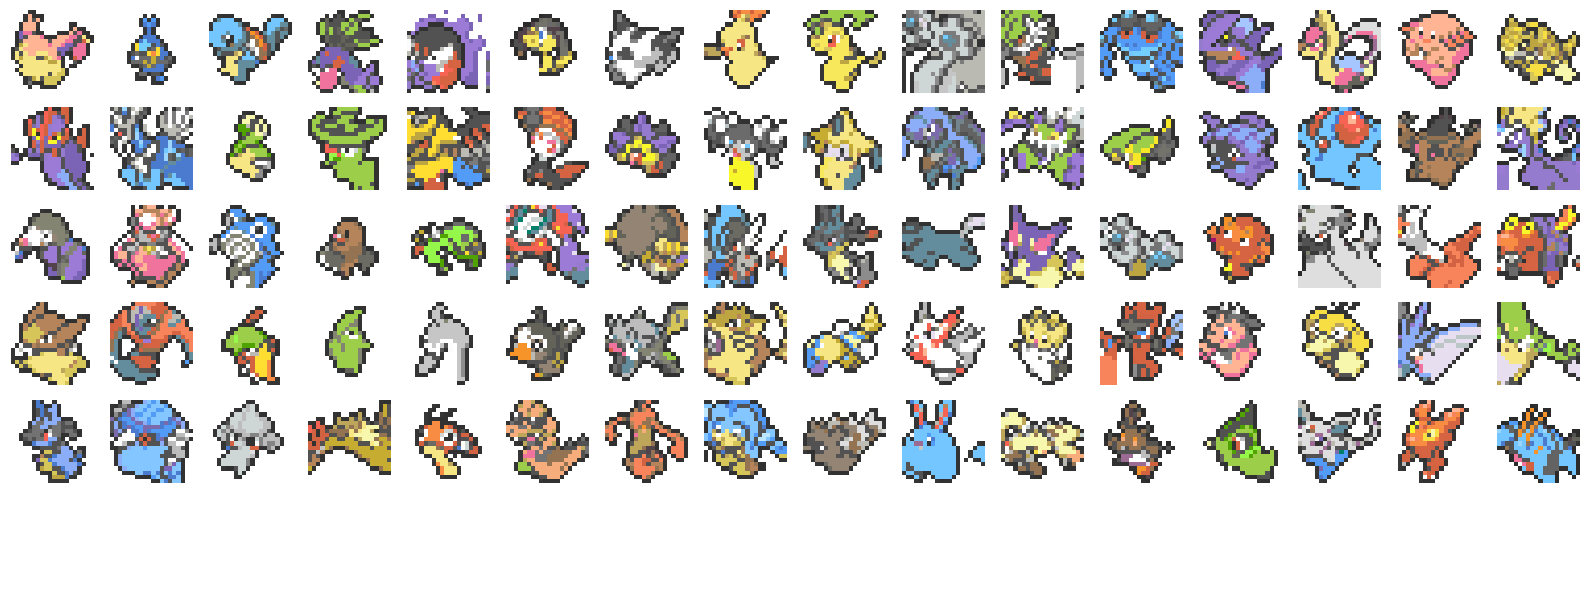

In [18]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)